## Xgboost+Lagging (지표만으로 학습)

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, kruskal, shapiro, pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.cm as cm
import koreanize_matplotlib

df_area = pd.read_csv("서울시 상권분석서비스(영역-상권).csv", encoding='cp949')
df_income = pd.read_csv("서울시 상권분석서비스(소득소비-자치구).csv", encoding='cp949')
df_sales = pd.read_csv("서울시 상권분석서비스(추정매출-자치구).csv", encoding='cp949')
df_store = pd.read_csv("서울시 상권분석서비스(점포-자치구).csv", encoding="cp949")
df_income['기준_년분기_코드'].unique()

df_area = df_area.rename(columns={
    "자치구_코드_명": "자치구",
    "영역_면적": "상권면적"
})

df_income = df_income.rename(columns={
    "행정동_코드_명": "자치구",
    "지출_총금액": "총지출",
    "월_평균_소득_금액": "평균소득"
})

df_sales = df_sales.rename(columns={
    "자치구_코드_명": "자치구",
    "당월_매출_금액": "총추정매출",
    "서비스_업종_코드_명": "업종명"
})

df_store = df_store.rename(columns={
    "자치구_코드_명": "자치구",
    "점포_수": "점포수",
    "서비스_업종_코드_명": "업종명",
    "유사_업종_점포_수": "유사점포수",
    "폐업_점포_수": "폐업점포수",
    "폐업_률": "폐업률"
})

## 업종 매핑
category_map = {
    '외식업': ['한식음식점', '일식음식점', '중식음식점', '양식음식점', '치킨전문점', '분식전문점', '패스트푸드점', '호프-간이주점'],
    '카페/디저트' : ['커피-음료', '제과점'],
    '소매/도소매': ['편의점', '서적', '가구', '가방', '가전제품', '문구', '미곡판매', '미용재료', '수산물판매', '슈퍼마켓', '시계및귀금속', '신발', '악기', '안경',
                 '예술품', '운동/경기용품', '육류판매', '의료기기', '의류임대', '의약품', '재생용품 판매점',
                 '전자상거래업', '조명용품', '주류도매', '중고가구', '중고차판매', '철물점', '청과상', '컴퓨터및주변장치판매', '핸드폰', '화장품', '화초'],
    '뷰티/건강': ['미용실', '네일숍', '피부관리실', '동물병원', '일반의원', '치과의원', '한의원'],
    '유아/아동 관련': ['완구', '유아의류'],
    '교육': ['독서실', '예술학원', '외국어학원', '일반교습학원', '컴퓨터학원', '스포츠 강습'],
    '생활 서비스': ['가전제품수리', '가정용품임대', '건축물청소', '세탁소', '사진관', '세무사사무소', '법무사사무소', '변리사사무소', '변호사사무소',
                 '통번역서비스', '통신기기수리', '회계사사무소', '인테리어', '기타법무서비스'],
    '자동차/운송': ['모터사이클및부품', '모터사이클수리', '자동차미용', '자동차부품', '자동차수리', '자전거 및 기타운송장비', '주유소'],
    '주거/부동산': ['부동산중개업', '고시원'],
    '숙박/배달': ['게스트하우스', '여관', '여행사'],
    '엔터테인먼트/오락': ['DVD방', 'PC방', '노래방', '녹음실', '당구장', '볼링장',
                  '전자게임장', '기타오락장', '복권방', '스포츠클럽', '골프연습장', '비디오/서적임대'],
    '패션/의류': ['섬유제품', '한복점', '일반의류',]
}

reverse_map = {}
for category, 업종들 in category_map.items():
    for 업종 in 업종들:
        reverse_map[업종] = category

df_store["대분류"] = df_store["업종명"].map(reverse_map)
df_sales["대분류"] = df_sales["업종명"].map(reverse_map)


# 연도 칼럼
df_store["year"] = df_store["기준_년분기_코드"] // 10
df_sales["year"] = df_sales["기준_년분기_코드"] // 10
df_income["year"] = df_income["기준_년분기_코드"] // 10


# 매출 데이터 집계(해당 분기 자치구-업종별 총추정매출)
df_sales_agg = df_sales.groupby(
    ["기준_년분기_코드", "자치구", "업종명"], as_index=False
).agg({
    "총추정매출": "sum"
})

## 자치구별 면적 계산
df_area_agg = df_area.groupby("자치구", as_index=False)["상권면적"].sum()
df_region_area = df_area_agg[["자치구", "상권면적"]]


# 자치구별 연 단위 총지출 집계
df_income_agg = df_income.groupby(["자치구", "year"], as_index=False).agg({
    "총지출": "sum",
    "평균소득": "mean"
})
df_region_income = df_income_agg[["자치구", "year", "총지출", "평균소득"]]

df_merged = pd.merge(
    df_store[[
        "기준_년분기_코드", "자치구", "업종명", "대분류",
        "점포수", "유사점포수", "폐업점포수", "폐업률", "year"
    ]],
    df_sales_agg,
    on=["기준_년분기_코드", "자치구", "업종명"],
    how="left"
)

df_region = pd.merge(
    df_merged,
    df_income_agg,
    on=["자치구", "year"],
    how="left"
)

df_final = pd.merge(
    df_region,
    df_area_agg[["자치구", "상권면적"]],
    on="자치구",
    how="left"
)

## 분기
quarter_code = 20234

df_final_2023 = df_final[df_final["year"] == 2023].copy()
df_final_q4 = df_final[df_final["기준_년분기_코드"] == quarter_code].copy()
df_final.shape


(59725, 13)

In [16]:
df_final.tail()
df_final['기준_년분기_코드'].unique()

array([20244, 20243, 20242, 20241, 20234, 20233, 20232, 20231, 20224,
       20223, 20222, 20221, 20214, 20213, 20212, 20211, 20204, 20203,
       20202, 20201, 20194, 20193, 20192, 20191])

In [17]:
df_final.head()

,기준_년분기_코드,자치구,업종명,대분류,점포수,유사점포수,폐업점포수,폐업률,year,총추정매출,총지출,평균소득,상권면적
0,20244,강동구,전자상거래업,소매/도소매,1100.0,1100.0,63.0,5.7,2024,60224799.0,417853383000,3292857.0,5761011
1,20244,강동구,주유소,자동차/운송,39.0,39.0,0.0,0.0,2024,NaN,417853383000,3292857.0,5761011
2,20244,강동구,예술품,소매/도소매,26.0,26.0,0.0,0.0,2024,NaN,417853383000,3292857.0,5761011
3,20244,강동구,재생용품 판매점,소매/도소매,47.0,47.0,0.0,0.0,2024,NaN,417853383000,3292857.0,5761011
4,20244,강동구,모터사이클및부품,자동차/운송,20.0,20.0,0.0,0.0,2024,NaN,417853383000,3292857.0,5761011


In [18]:
p_df=pd.read_csv('./서울시 상권분석서비스(길단위인구-자치구).csv',encoding='cp949') 
p_df.head()
p_df['기준_년분기_코드'].unique()


array([20244, 20241, 20242, 20243, 20191, 20192, 20193, 20194, 20201,
       20202, 20203, 20204, 20211, 20212, 20213, 20214, 20221, 20222,
       20223, 20224, 20233, 20231, 20232, 20234])

In [19]:
p_df.head()

,기준_년분기_코드,자치구_코드,자치구_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,연령대_30_유동인구_수,연령대_40_유동인구_수,...,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_24_유동인구_수,월요일_유동인구_수,화요일_유동인구_수,수요일_유동인구_수,목요일_유동인구_수,금요일_유동인구_수,토요일_유동인구_수,일요일_유동인구_수
0,20244,11110,종로구,67784322,32394267,35390055,7312618,13379615,10778714,10895276,...,10752507,12139106,7230041,9788409,9901461,10025130,10053356,10060456,9321977,8633531
1,20241,11170,용산구,62142113,29670426,32471688,7429032,9812035,12530096,11114777,...,7668788,10183238,7731652,8803217,8878841,8910656,8907194,8890216,8847055,8904933
2,20242,11170,용산구,59713443,28394354,31319089,7380158,9592079,12117541,10682667,...,7426692,9867216,7455527,8495796,8552480,8525357,8549793,8586993,8521931,8481094
3,20243,11170,용산구,58581054,27980450,30600604,7185505,9348723,11870028,10502581,...,7345140,9709794,7284340,8310560,8327284,8402778,8407960,8467722,8353466,8311283
4,20244,11170,용산구,59598747,28316074,31282672,7283541,9672781,12050182,10694683,...,7531560,9977802,7393686,8421511,8457542,8529855,8512753,8570992,8615782,8490312


In [20]:
# 컬럼명 일치시키기
p_df = p_df.rename(columns={'자치구_코드_명': '자치구'})


In [21]:
df_final['기준_년분기_코드'] = df_final['기준_년분기_코드'].astype(int)
p_df['기준_년분기_코드'] = p_df['기준_년분기_코드'].astype(int)


In [22]:
df_merged = pd.merge(
    df_final,
    p_df[['기준_년분기_코드', '자치구', '총_유동인구_수']],
    on=['기준_년분기_코드', '자치구'],
    how='left'  # 유동인구 없는 자치구도 유지
)


In [23]:
print(df_merged[['기준_년분기_코드', '자치구', '업종명', '총_유동인구_수']].head())
print(f"유동인구 누락 행 수: {df_merged['총_유동인구_수'].isna().sum()}개")

   기준_년분기_코드  자치구       업종명   총_유동인구_수
0      20244  강동구    전자상거래업  107151778
1      20244  강동구       주유소  107151778
2      20244  강동구       예술품  107151778
3      20244  강동구  재생용품 판매점  107151778
4      20244  강동구  모터사이클및부품  107151778
유동인구 누락 행 수: 0개


In [24]:
df_merged.head(3)

,기준_년분기_코드,자치구,업종명,대분류,점포수,유사점포수,폐업점포수,폐업률,year,총추정매출,총지출,평균소득,상권면적,총_유동인구_수
0,20244,강동구,전자상거래업,소매/도소매,1100.0,1100.0,63.0,5.7,2024,60224799.0,417853383000,3292857.0,5761011,107151778
1,20244,강동구,주유소,자동차/운송,39.0,39.0,0.0,0.0,2024,NaN,417853383000,3292857.0,5761011,107151778
2,20244,강동구,예술품,소매/도소매,26.0,26.0,0.0,0.0,2024,NaN,417853383000,3292857.0,5761011,107151778


In [25]:
df_merged.shape

(59725, 14)

In [26]:
# 1. 폐업률 (% 단위)
df_merged['폐업률'] = df_merged.apply(
    lambda row: (row['폐업점포수'] / row['점포수'] * 100) if row['점포수'] > 0 else 0,
    axis=1
)

# 2. 밀집도
df_merged['밀집도'] = df_merged.apply(
    lambda row: (row['유사점포수'] / row['상권면적']) if row['상권면적'] > 0 else 0,
    axis=1
)

# 3. 점포당 평균 매출
df_merged['점포당_평균_매출'] = df_merged.apply(
    lambda row: (row['총추정매출'] / row['점포수']) if row['점포수'] > 0 else 0,
    axis=1
)


In [ ]:
# 유동인구 대비 점포 수
# df_merged['유동인구_대비_점포'] = df_merged['점포수'] / df_merged['총_유동인구_수']

# # 자치구 내 업종 점유율
# df_merged['자치구_업종_점유율'] = df_merged.groupby('자치구')['점포수'].transform(lambda x: x / x.sum())


In [27]:
df_merged.shape

(59725, 16)

In [28]:
df_merged.drop('유사점포수', axis=1, inplace=True)  

In [29]:
df_merged.head()

,기준_년분기_코드,자치구,업종명,대분류,점포수,폐업점포수,폐업률,year,총추정매출,총지출,평균소득,상권면적,총_유동인구_수,밀집도,점포당_평균_매출
0,20244,강동구,전자상거래업,소매/도소매,1100.0,63.0,5.727273,2024,60224799.0,417853383000,3292857.0,5761011,107151778,0.000191,54749.817273
1,20244,강동구,주유소,자동차/운송,39.0,0.0,0.000000,2024,NaN,417853383000,3292857.0,5761011,107151778,0.000007,NaN
2,20244,강동구,예술품,소매/도소매,26.0,0.0,0.000000,2024,NaN,417853383000,3292857.0,5761011,107151778,0.000005,NaN
3,20244,강동구,재생용품 판매점,소매/도소매,47.0,0.0,0.000000,2024,NaN,417853383000,3292857.0,5761011,107151778,0.000008,NaN
4,20244,강동구,모터사이클및부품,자동차/운송,20.0,0.0,0.000000,2024,NaN,417853383000,3292857.0,5761011,107151778,0.000003,NaN


In [30]:
df_merged.isna().sum()

기준_년분기_코드        0
자치구              0
업종명              0
대분류           1200
점포수              0
폐업점포수            0
폐업률              0
year             0
총추정매출        22816
총지출              0
평균소득             0
상권면적             0
총_유동인구_수         0
밀집도              0
점포당_평균_매출    22795
dtype: int64

In [31]:
df_merged['점포당_평균_매출'].fillna(0, inplace=True)

/var/folders/q9/1gz00szn5vz5011w8pll4_8h0000gn/T/ipykernel_1033/136733743.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['점포당_평균_매출'].fillna(0, inplace=True)


In [32]:
df_merged.isna().sum()

기준_년분기_코드        0
자치구              0
업종명              0
대분류           1200
점포수              0
폐업점포수            0
폐업률              0
year             0
총추정매출        22816
총지출              0
평균소득             0
상권면적             0
총_유동인구_수         0
밀집도              0
점포당_평균_매출        0
dtype: int64

In [33]:
df=df_merged.copy()

In [21]:
# xgboost만으로는 시계열을 반영할 수 없음(단순 회귀)
# 시계열을 반영하기 위해서는 lagging을 해야함
# Lag 변수와 시간 변수로 시계열성을 반영할 수 있음
# Lagging: 과거 시점의 데이터를 현재 시점의 feature로 사용 
# Lag Feature: 폐업률_t-1, 매출_t-1 등 과거 분기 데이터를 feature로 사용


In [38]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. 데이터 준비
df = df_merged.copy()
df = df.sort_values(by=['자치구', '업종명', '기준_년분기_코드'])

# 2. Lag Feature 생성
df['폐업률_lag1'] = df.groupby(['자치구', '업종명'])['폐업률'].shift(1)
df['점포당_평균_매출_lag1'] = df.groupby(['자치구', '업종명'])['점포당_평균_매출'].shift(1)
df['총_유동인구_수_lag1'] = df.groupby(['자치구', '업종명'])['총_유동인구_수'].shift(1)

features = ['폐업률_lag1', '점포당_평균_매출_lag1', '총_유동인구_수_lag1']

# ==========================================
# 폐업률 예측
df_model = df.dropna(subset=features + ['폐업률'])
X = df_model[features]
y = df_model['폐업률']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model_closure = XGBRegressor(n_estimators=30, random_state=42)
model_closure.fit(X_train, y_train)
df['예측_폐업률'] = model_closure.predict(df[features].fillna(0))

# 성능 평가
y_pred = model_closure.predict(X_test)
print("폐업률 성능:")
print("MAE:", round(mean_absolute_error(y_test, y_pred), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))
print("R²:", round(r2_score(y_test, y_pred), 4))

# ==========================================
# 점포당 매출 예측
df_model_sales = df.dropna(subset=features + ['점포당_평균_매출'])
X_sales = df_model_sales[features]
y_sales = df_model_sales['점포당_평균_매출']
X_sales_train, X_sales_test, y_sales_train, y_sales_test = train_test_split(X_sales, y_sales, shuffle=False, test_size=0.2)

model_sales = XGBRegressor(n_estimators=30, random_state=42)
model_sales.fit(X_sales_train, y_sales_train)
df['예측_매출'] = model_sales.predict(df[features].fillna(0))

# 성능 평가
y_sales_pred = model_sales.predict(X_sales_test)
print("\n매출 성능:")
print("MAE:", round(mean_absolute_error(y_sales_test, y_sales_pred), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_sales_test, y_sales_pred)), 2))
print("R²:", round(r2_score(y_sales_test, y_sales_pred), 4))

# ==========================================
# 유동인구 예측
df_model_pop = df.dropna(subset=features + ['총_유동인구_수'])
X_pop = df_model_pop[features]
y_pop = df_model_pop['총_유동인구_수']
X_pop_train, X_pop_test, y_pop_train, y_pop_test = train_test_split(X_pop, y_pop, shuffle=False, test_size=0.2)

model_pop = XGBRegressor(n_estimators=30, random_state=42)
model_pop.fit(X_pop_train, y_pop_train)
df['예측_유동인구'] = model_pop.predict(df[features].fillna(0))

# 성능 평가
y_pop_pred = model_pop.predict(X_pop_test)
print("\n유동인구 성능:")
print("MAE:", round(mean_absolute_error(y_pop_test, y_pop_pred)))
print("RMSE:", round(np.sqrt(mean_squared_error(y_pop_test, y_pop_pred))))
print("R²:", round(r2_score(y_pop_test, y_pop_pred), 4))

# ==========================================
# 정규화 및 추천 점수 계산
scaler = MinMaxScaler()
df['정규_예측_매출'] = scaler.fit_transform(df[['예측_매출']])
df['정규_예측_폐업률'] = scaler.fit_transform(df[['예측_폐업률']])
df['정규_예측_유동인구'] = scaler.fit_transform(df[['예측_유동인구']])

df['추천_점수'] = (
    0.4 * df['정규_예측_매출'] +
    0.3 * (1 - df['정규_예측_폐업률']) +
    0.3 * df['정규_예측_유동인구']
)

# 자치구 추천
user_input_upjong = '전자상거래업'
df_recommend = df[df['업종명'] == user_input_upjong]
df_grouped = df_recommend.groupby('자치구')['추천_점수'].mean().reset_index()
df_grouped = df_grouped.sort_values(by='추천_점수', ascending=False)

print("\n추천 자치구 TOP 5:")
print(df_grouped.head(5))


폐업률 성능:
MAE: 2.1327
RMSE: 4.2205
R²: 0.064

매출 성능:
MAE: 4616243.57
RMSE: 14655344.29
R²: 0.9562

유동인구 성능:
MAE: 2787729
RMSE: 4157803
R²: 0.9482

추천 자치구 TOP 5:
    자치구     추천_점수
0   강남구  0.556631
4   관악구  0.520899
17  송파구  0.506227
16  성북구  0.494795
12  마포구  0.487478


In [46]:
df.columns

Index(['기준_년분기_코드', '자치구', '업종명', '대분류', '점포수', '폐업점포수', '폐업률', 'year',
       '총추정매출', '총지출', '평균소득', '상권면적', '총_유동인구_수', '밀집도', '점포당_평균_매출',
       '폐업률_lag1', '점포당_평균_매출_lag1', '총_유동인구_수_lag1', '예측_폐업률', '예측_매출',
       '예측_유동인구', '정규_예측_매출', '정규_예측_폐업률', '정규_예측_유동인구', '추천_점수'],
      dtype='object')

In [49]:
df['기준_년분기_코드'].unique()    

array([20191, 20192, 20193, 20194, 20201, 20202, 20203, 20204, 20211,
       20212, 20213, 20214, 20221, 20222, 20223, 20224, 20231, 20232,
       20233, 20234, 20241, 20242, 20243, 20244])

In [56]:
import numpy as np
import pandas as pd

# 예측 대상 분기
next_quarter = 20251
future_records = []

# 자치구-업종별 그룹화
grouped = df.groupby(['자치구', '업종명'])

for (gu, upjong), group in grouped:
    group = group.sort_values(by='기준_년분기_코드')
    last_row = group.iloc[-1]

    # 필요한 lag 데이터가 모두 있는 경우에만 예측 수행
    if pd.notnull(last_row['폐업률']) and pd.notnull(last_row['점포당_평균_매출']) and pd.notnull(last_row['총_유동인구_수']):
        input_features = np.array([[
            last_row['폐업률'],
            last_row['점포당_평균_매출'],
            last_row['총_유동인구_수']
        ]])

        # 3개 모델 예측
        pred_closure = model_closure.predict(input_features)[0]
        pred_sales = model_sales.predict(input_features)[0]
        pred_pop = model_pop.predict(input_features)[0]

        # 결과 저장
        future_records.append({
            '자치구': gu,
            '업종명': upjong,
            '기준_년분기_코드': next_quarter,
            '폐업률_lag1': last_row['폐업률'],
            '점포당_평균_매출_lag1': last_row['점포당_평균_매출'],
            '총_유동인구_수_lag1': last_row['총_유동인구_수'],
            '예측_폐업률': pred_closure,
            '예측_매출': pred_sales,
            '예측_유동인구': pred_pop
        })

# 결과를 DataFrame으로 정리
df_future_20251 = pd.DataFrame(future_records)

# 기존 df와 병합하고 싶다면:
df_combined = pd.concat([df, df_future_20251], ignore_index=True)

# 결과 확인
print("예측 완료: 2025년 1분기 데이터")
print(df_future_20251.head())


예측 완료: 2025년 1분기 데이터
   자치구   업종명  기준_년분기_코드  폐업률_lag1  점포당_평균_매출_lag1  총_유동인구_수_lag1    예측_폐업률  \
0  강남구  DVD방      20251  0.000000    0.000000e+00      144164615  4.076093   
1  강남구   PC방      20251  7.792208    1.068804e+08      144164615  8.619418   
2  강남구    가구      20251  1.792829    8.104171e+07      144164615  2.041241   
3  강남구    가방      20251  2.153846    6.510252e+07      144164615  2.384933   
4  강남구  가전제품      20251  1.257862    3.437699e+06      144164615  2.135274   

          예측_매출      예측_유동인구  
0 -1.518927e+05  142076448.0  
1  1.057986e+08  141687184.0  
2  8.126714e+07  142133200.0  
3  6.605604e+07  142133200.0  
4  3.238097e+06  142099120.0  


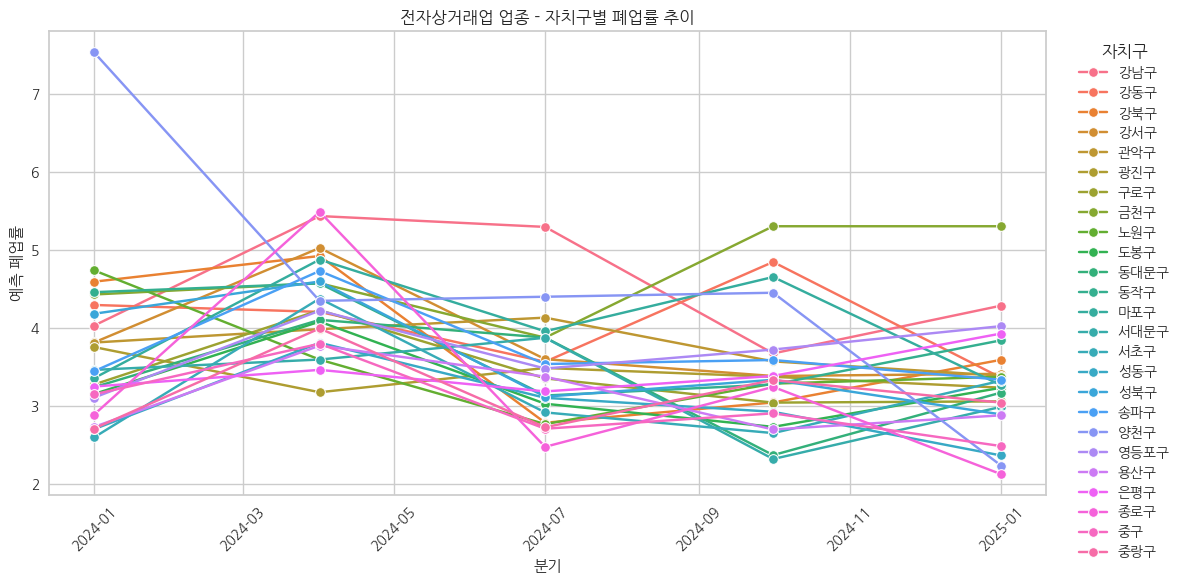

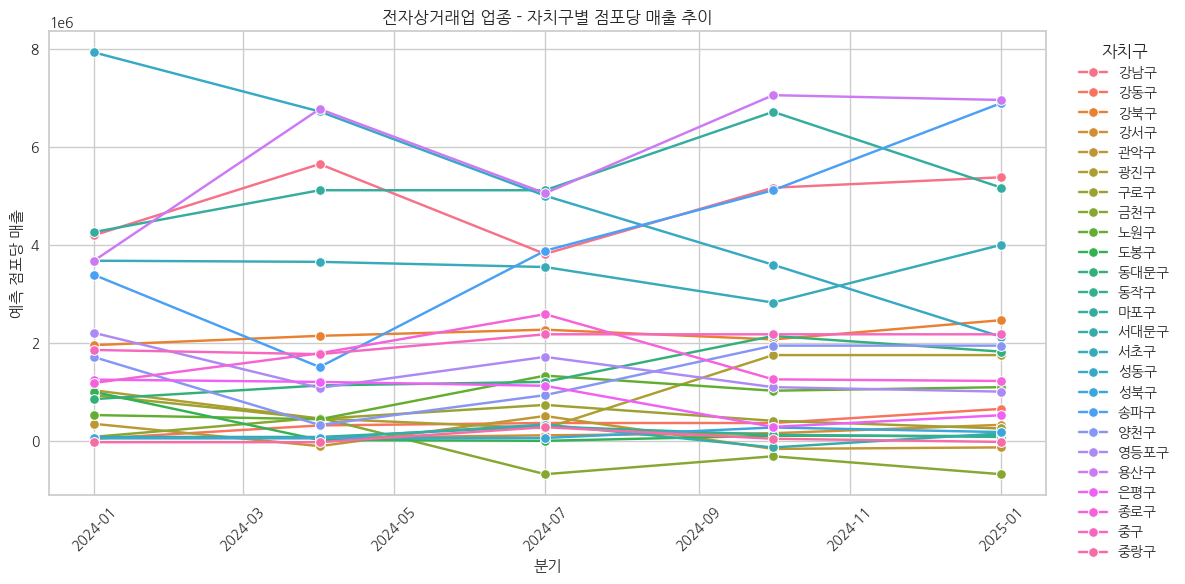

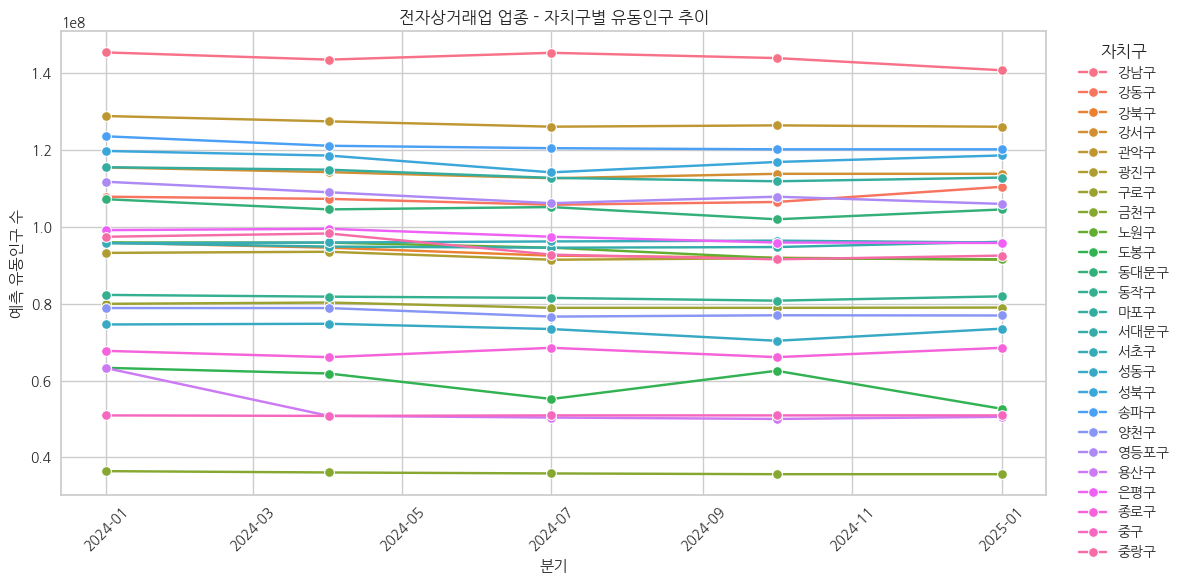

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 날짜 변환 함수
def convert_quarter_to_date(code):
    year = str(code)[:4]
    quarter = str(code)[-1]
    month = {'1': '01', '2': '04', '3': '07', '4': '10'}.get(quarter, '01')
    return pd.to_datetime(f"{year}-{month}-01")

# 예측 데이터 결합
df_future_20251['date'] = df_future_20251['기준_년분기_코드'].apply(convert_quarter_to_date)
df_combined = pd.concat([df, df_future_20251], ignore_index=True)

# 전체 데이터 date 생성
df_combined['date'] = df_combined['기준_년분기_코드'].apply(convert_quarter_to_date)

# 원하는 업종 선택
target_upjong = '전자상거래업'
df_filtered = df_combined[df_combined['업종명'] == target_upjong].copy()

# 최근 4분기 + 예측 1분기만 추출 (최신 5개 분기)
latest_dates = sorted(df_filtered['기준_년분기_코드'].unique())[-5:]
df_recent = df_filtered[df_filtered['기준_년분기_코드'].isin(latest_dates)]


def plot_gu_trend(df, value_col, title, ylabel):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='date', y=value_col, hue='자치구', marker='o')
    plt.title(title)
    plt.xlabel('분기')
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend(title='자치구', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_gu_trend(df_recent, '예측_폐업률', f'{target_upjong} 업종 - 자치구별 폐업률 추이', '예측 폐업률')
plot_gu_trend(df_recent, '예측_매출', f'{target_upjong} 업종 - 자치구별 점포당 매출 추이', '예측 점포당 매출')
plot_gu_trend(df_recent, '예측_유동인구', f'{target_upjong} 업종 - 자치구별 유동인구 추이', '예측 유동인구 수')


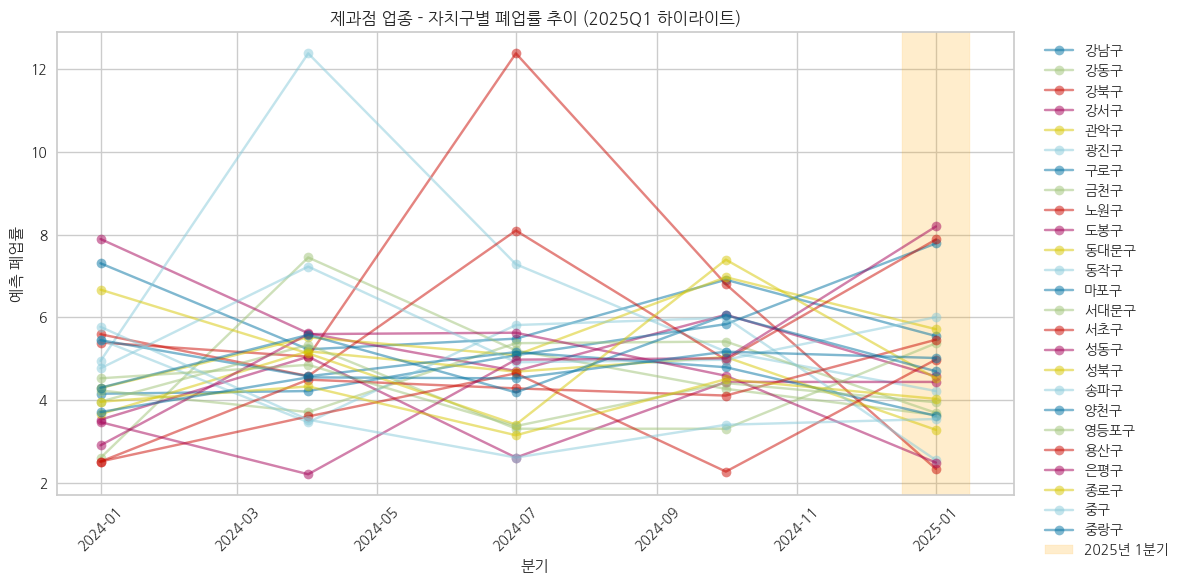

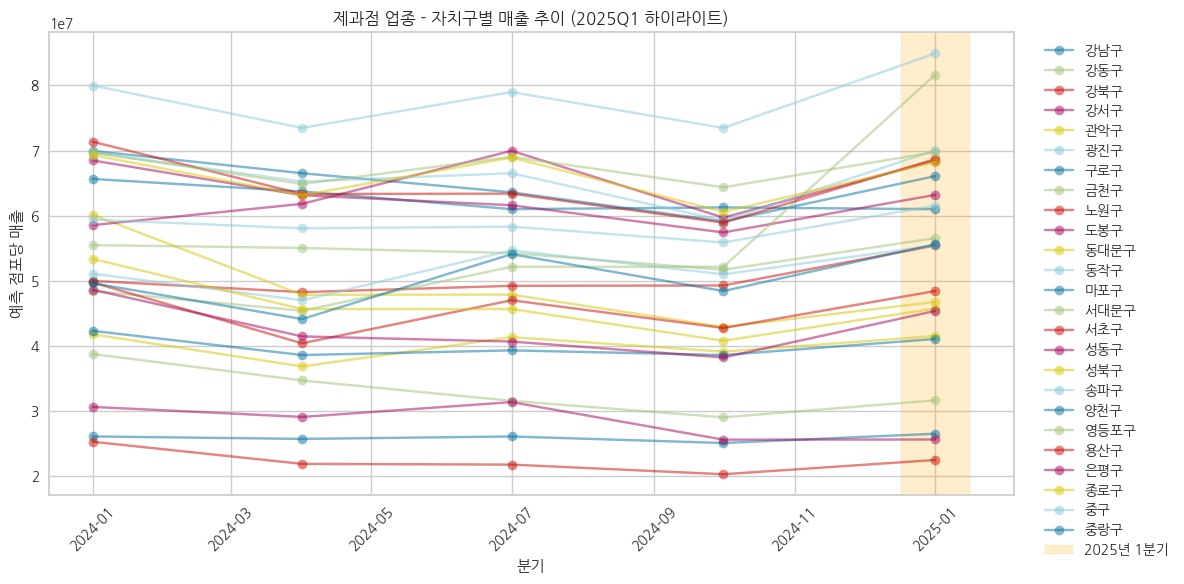

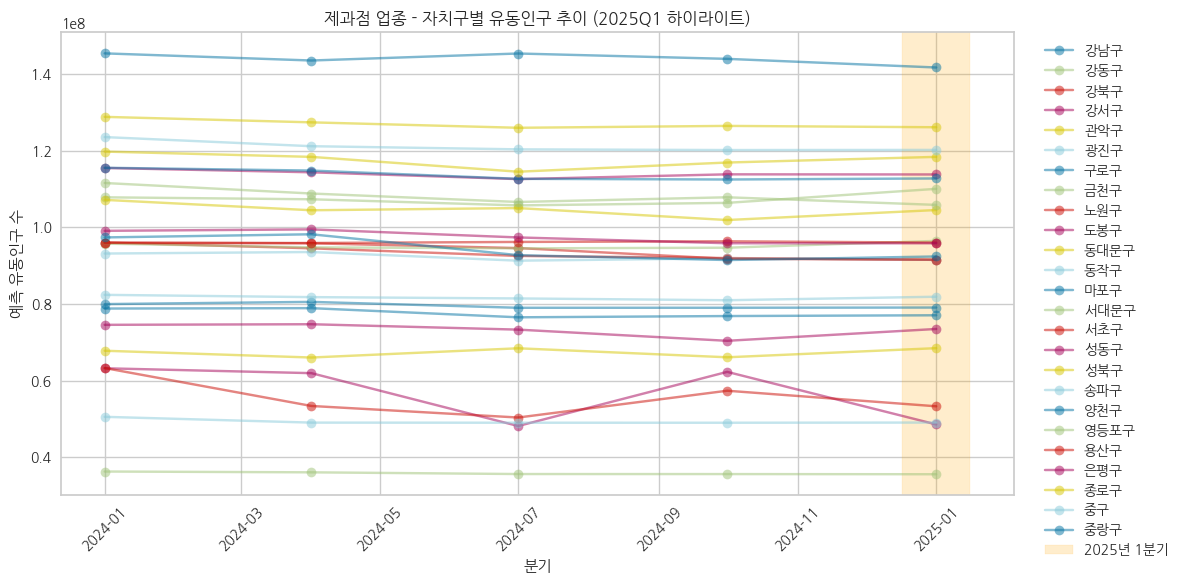

In [ ]:

# 1. 날짜 변환 함수
def convert_quarter_to_date(code):
    year = str(code)[:4]
    quarter = str(code)[-1]
    month = {'1': '01', '2': '04', '3': '07', '4': '10'}.get(quarter, '01')
    return pd.to_datetime(f"{year}-{month}-01")

# 2. 날짜 컬럼 생성
df_combined['date'] = df_combined['기준_년분기_코드'].apply(convert_quarter_to_date)

# 3. 대상 업종 필터링
target_upjong = '제과점'
df_upjong = df_combined[df_combined['업종명'] == target_upjong]

# 4. 최근 5개 분기 기준 정렬
recent_quarters = sorted(df_upjong['기준_년분기_코드'].unique())[-5:]
df_recent = df_upjong[df_upjong['기준_년분기_코드'].isin(recent_quarters)]

highlight_quarter = 20251
highlight_date = convert_quarter_to_date(highlight_quarter)

# 5. 그래프 함수 정의
def plot_with_background_highlight(df, value_col, title, ylabel):
    plt.figure(figsize=(12, 6))

    # 선그래프 전체
    for gu in df['자치구'].unique():
        sub = df[df['자치구'] == gu]
        plt.plot(sub['date'], sub[value_col], marker='o', label=gu, alpha=0.5)

    highlight_date = convert_quarter_to_date(20251)
    plt.axvspan(highlight_date - pd.Timedelta(days=15), highlight_date + pd.Timedelta(days=15),
                color='orange', alpha=0.2, label='2025년 1분기')

    plt.title(title)
    plt.xlabel('분기')
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()





plot_with_background_highlight(df_recent, '예측_폐업률', f'{target_upjong} 업종 - 자치구별 폐업률 추이 (2025Q1 하이라이트)', '예측 폐업률')
plot_with_background_highlight(df_recent, '예측_매출', f'{target_upjong} 업종 - 자치구별 매출 추이 (2025Q1 하이라이트)', '예측 점포당 매출')
plot_with_background_highlight(df_recent, '예측_유동인구', f'{target_upjong} 업종 - 자치구별 유동인구 추이 (2025Q1 하이라이트)', '예측 유동인구 수')


In [ ]:
df_20251 = df_recent[df_recent['기준_년분기_코드'] == 20251]
top5_gu = df_20251.sort_values(by='추천_점수', ascending=False).head(5)
top5_summary = top5_gu[['자치구', '예측_폐업률', '예측_매출', '예측_유동인구', '추천_점수']].reset_index(drop=True)

print("✅ 종합점수 Top5 자치구 (2025년 1분기 기준)")
print(top5_summary)


✅ 종합점수 Top5 자치구 (2025년 1분기 기준)
   자치구    예측_폐업률       예측_매출      예측_유동인구  추천_점수
0  강남구  5.545269  61003404.0  141737264.0    NaN
1  강동구  3.636342  56554096.0  110062824.0    NaN
2  강북구  2.332496  55429428.0   91528920.0    NaN
3  강서구  4.570926  63197908.0  113818120.0    NaN
4  관악구  5.711212  46761504.0  126141816.0    NaN


In [ ]:
# '제과점' 기준으로 업종 필터링
df_target = df_combined[df_combined['업종명'] == '제과점']
df_20251 = df_target[df_target['기준_년분기_코드'] == 20251].copy()

df_20251['추천_점수'] = (
    0.4 * df_20251['정규_예측_매출'] +
    0.3 * (1 - df_20251['정규_예측_폐업률']) +
    0.3 * df_20251['정규_예측_유동인구']
)

top5_gu = df_20251.sort_values(by='추천_점수', ascending=False).head(5)
top5_table = top5_gu[['자치구', '예측_폐업률', '예측_매출', '예측_유동인구', '추천_점수']].reset_index(drop=True)

print("제과점 업종 2025년 1분기 종합 점수 Top5 자치구")
print(top5_table)


제과점 업종 2025년 1분기 종합 점수 Top5 자치구
   자치구    예측_폐업률       예측_매출      예측_유동인구  추천_점수
0  강남구  5.545269  61003404.0  141737264.0    NaN
1  강동구  3.636342  56554096.0  110062824.0    NaN
2  강북구  2.332496  55429428.0   91528920.0    NaN
3  강서구  4.570926  63197908.0  113818120.0    NaN
4  관악구  5.711212  46761504.0  126141816.0    NaN


In [ ]:
df_merged.shape

(59725, 15)

In [71]:
top5_gu

,기준_년분기_코드,자치구,업종명,대분류,점포수,폐업점포수,폐업률,year,총추정매출,총지출,...,점포당_평균_매출_lag1,총_유동인구_수_lag1,예측_폐업률,예측_매출,예측_유동인구,정규_예측_매출,정규_예측_폐업률,정규_예측_유동인구,추천_점수,date
59798,20251,강남구,제과점,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.119242e+07,144164615.0,5.545269,61003404.0,141737264.0,NaN,NaN,NaN,NaN,2025-01-01
59898,20251,강동구,제과점,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.555644e+07,107151778.0,3.636342,56554096.0,110062824.0,NaN,NaN,NaN,NaN,2025-01-01
59998,20251,강북구,제과점,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.100780e+07,91622385.0,2.332496,55429428.0,91528920.0,NaN,NaN,NaN,NaN,2025-01-01
60098,20251,강서구,제과점,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.288792e+07,113675043.0,4.570926,63197908.0,113818120.0,NaN,NaN,NaN,NaN,2025-01-01
60198,20251,관악구,제과점,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.805123e+07,126296711.0,5.711212,46761504.0,126141816.0,NaN,NaN,NaN,NaN,2025-01-01


In [ ]:
df['date'] = df['분기코드'].apply(convert_quarter_to_date)
df_future = df[df['분기코드'] == 20251].copy()

In [ ]:
# '제과점' 필터링
df_bakery = df[df['업종명'] == '제과점'].copy()

summary_line = df_bakery.groupby('자치구').agg({
    '예측_폐업률': ['mean', 'std'],
    '예측_매출': ['mean', 'std'],
    '예측_유동인구': ['mean', 'std']
}).reset_index()

summary_line.columns = [
    '자치구',
    '폐업률_mean', '폐업률_std',
    '매출_mean', '매출_std',
    '유동인구_mean', '유동인구_std'
]

summary_line['x'] = np.arange(len(summary_line))


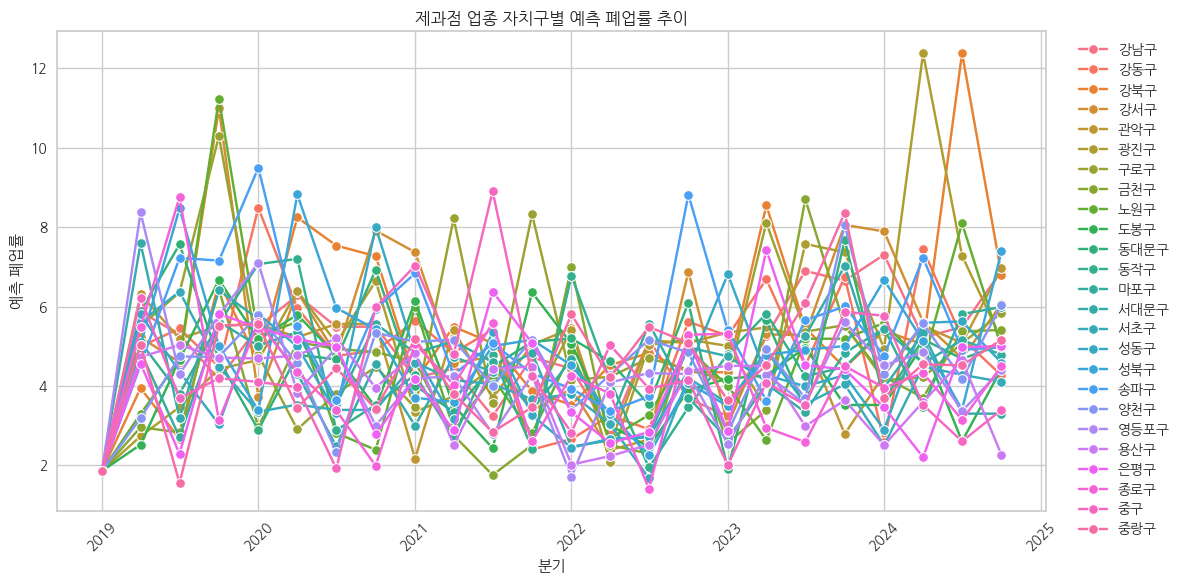

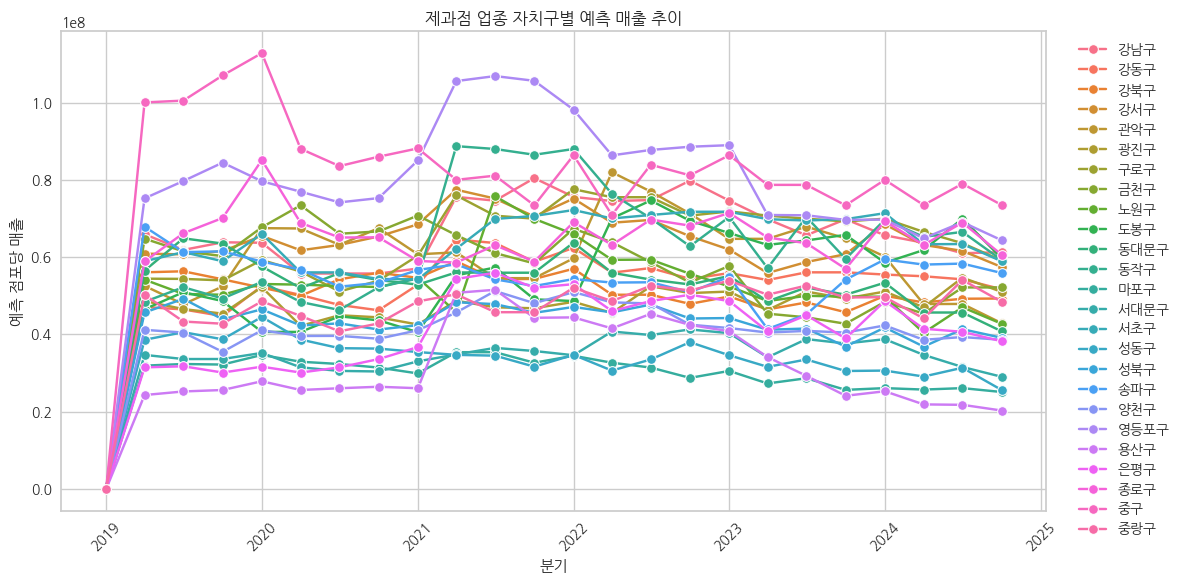

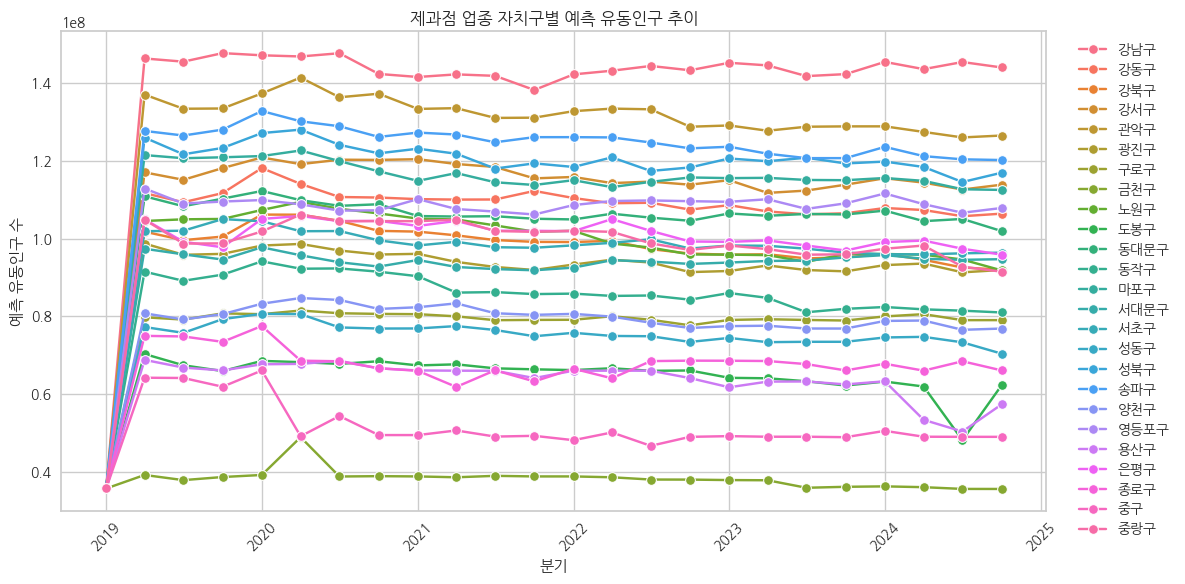

In [ ]:

df_bakery = df[df['업종명'] == '제과점'].copy()

def convert_quarter_to_date(code):
    year = str(code)[:4]
    quarter = str(code)[-1]
    month = {'1': '01', '2': '04', '3': '07', '4': '10'}[quarter]
    return pd.to_datetime(f"{year}-{month}-01")

df_bakery['date'] = df_bakery['기준_년분기_코드'].apply(convert_quarter_to_date)

def lineplot_by_gu(df, value_col, title, ylabel):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='date', y=value_col, hue='자치구', marker='o')
    plt.title(title)
    plt.xlabel('분기')
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 예측 폐업률 추이
lineplot_by_gu(df_bakery, '예측_폐업률', '제과점 업종 자치구별 예측 폐업률 추이', '예측 폐업률')

# 예측 점포당 매출 추이
lineplot_by_gu(df_bakery, '예측_매출', '제과점 업종 자치구별 예측 매출 추이', '예측 점포당 매출')

# 예측 유동인구 추이
lineplot_by_gu(df_bakery, '예측_유동인구', '제과점 업종 자치구별 예측 유동인구 추이', '예측 유동인구 수')


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59725 entries, 57487 to 1867
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   기준_년분기_코드       59725 non-null  int64  
 1   자치구             59725 non-null  object 
 2   업종명             59725 non-null  object 
 3   대분류             58525 non-null  object 
 4   점포수             59725 non-null  float64
 5   폐업점포수           59725 non-null  float64
 6   폐업률             59725 non-null  float64
 7   year            59725 non-null  int64  
 8   총추정매출           36909 non-null  float64
 9   총지출             59725 non-null  int64  
 10  평균소득            59725 non-null  float64
 11  상권면적            59725 non-null  int64  
 12  총_유동인구_수        59725 non-null  int64  
 13  밀집도             59725 non-null  float64
 14  점포당_평균_매출       59725 non-null  float64
 15  폐업률_lag1        57225 non-null  float64
 16  점포당_평균_매출_lag1  57225 non-null  float64
 17  총_유동인구_수_lag1   57225 non-null  f

In [ ]:
# 폐업률을 거의 설명 못함
# 다른 요인들이 영향 미칠 수 있음
# 시계열적인 요소가 없음

In [37]:
df.shape

(59725, 25)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

features = ['폐업률_lag1', '점포당_평균_매출_lag1', '총_유동인구_수_lag1']
df_model = df.dropna(subset=features + ['폐업률'])

X = df_model[features]
y = df_model['폐업률']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# ✅ 예측에 사용할 모델 선택
#model_closure = RandomForestRegressor(n_estimators=100, random_state=42)
#model_closure = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_closure = LinearRegression()
model_closure = Ridge(alpha=1.0)

model_closure.fit(X_train, y_train)

y_pred = model_closure.predict(X_test)

print("폐업률 예측 성능 (선택 모델):")
print("MAE:", round(mean_absolute_error(y_test, y_pred), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))
print("R²:", round(r2_score(y_test, y_pred), 4))

df['예측_폐업률'] = model_closure.predict(df[features].fillna(0))


폐업률 예측 성능 (선택 모델):
MAE: 2.2588
RMSE: 4.2233
R²: 0.0627


/Users/leehyunjoo/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/leehyunjoo/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/leehyunjoo/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/leehyunjoo/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/leehyunjoo/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/leehyunjoo/Library/Python/3.9/lib/python/site-packages/sklearn/linear_m

In [26]:
# 다 성능 안좋음

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = df_merged.copy()
df = df.sort_values(by=['자치구', '업종명', '기준_년분기_코드'])

# Lag Feature 생성
df['폐업률_lag1'] = df.groupby(['자치구', '업종명'])['폐업률'].shift(1)
df['폐업률_lag2'] = df.groupby(['자치구', '업종명'])['폐업률'].shift(2)
df['폐업률_lag3'] = df.groupby(['자치구', '업종명'])['폐업률'].shift(3)

df['점포당_평균_매출_lag1'] = df.groupby(['자치구', '업종명'])['점포당_평균_매출'].shift(1)
df['총_유동인구_수_lag1'] = df.groupby(['자치구', '업종명'])['총_유동인구_수'].shift(1)

features = [
    '폐업률_lag1',
    '폐업률_lag2',
    '폐업률_lag3',
    '점포당_평균_매출_lag1',
    '총_유동인구_수_lag1'
]

df_model = df.dropna(subset=features + ['폐업률'])
X = df_model[features]
y = df_model['폐업률']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model_closure = XGBRegressor(n_estimators=30, random_state=42)
model_closure.fit(X_train, y_train)

y_pred = model_closure.predict(X_test)

print("폐업률 예측 성능 (lag2, lag3 포함):")
print("MAE:", round(mean_absolute_error(y_test, y_pred), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))
print("R²:", round(r2_score(y_test, y_pred), 4))

df['예측_폐업률'] = model_closure.predict(df[features].fillna(0))


폐업률 예측 성능 (lag2, lag3 포함):
MAE: 1.9888
RMSE: 4.1251
R²: 0.128


In [28]:
# 조금 개선되긴 함

In [ ]:

df = df_merged.copy()
df = df.sort_values(by=['자치구', '업종명', '기준_년분기_코드'])

# 연도, 분기 feature 생성
df['year'] = df['기준_년분기_코드'].astype(str).str[:4].astype(int)
df['quarter'] = df['기준_년분기_코드'].astype(str).str[-1].astype(int)

# 폐업률 lag1~lag4
for i in range(1, 5):
    df[f'폐업률_lag{i}'] = df.groupby(['자치구', '업종명'])['폐업률'].shift(i)

# 매출 lag1~lag3
for i in range(1, 4):
    df[f'점포당_평균_매출_lag{i}'] = df.groupby(['자치구', '업종명'])['점포당_평균_매출'].shift(i)

# 유동인구 lag1~lag2
for i in range(1, 3):
    df[f'총_유동인구_수_lag{i}'] = df.groupby(['자치구', '업종명'])['총_유동인구_수'].shift(i)

# 모델에 사용할 feature 선택
features = [
    '폐업률_lag1', '폐업률_lag2', '폐업률_lag3', 
    '점포당_평균_매출_lag1', '점포당_평균_매출_lag2', '점포당_평균_매출_lag3',
    
   'quarter'
]

# 모델용 데이터셋
df_model = df.dropna(subset=features + ['폐업률'])
X = df_model[features]
y = df_model['폐업률']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


model = XGBRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("폐업률 예측 성능 (긴 시계열 + 시간 정보 포함):")
print("MAE:", round(mean_absolute_error(y_test, y_pred), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))
print("R²:", round(r2_score(y_test, y_pred), 4))

df['예측_폐업률'] = model.predict(df[features].fillna(0))


폐업률 예측 성능 (긴 시계열 + 시간 정보 포함):
MAE: 2.0097
RMSE: 4.1267
R²: 0.1273


In [ ]:
df = df_merged.copy()
df = df.sort_values(by=['자치구', '업종명', '기준_년분기_코드'])

df['year'] = df['기준_년분기_코드'].astype(str).str[:4].astype(int)
df['quarter'] = df['기준_년분기_코드'].astype(str).str[-1].astype(int)

# 폐업률 lag1~lag4
for i in range(1, 5):
    df[f'폐업률_lag{i}'] = df.groupby(['자치구', '업종명'])['폐업률'].shift(i)

# 매출 lag1~lag3
for i in range(1, 4):
    df[f'점포당_평균_매출_lag{i}'] = df.groupby(['자치구', '업종명'])['점포당_평균_매출'].shift(i)

# 유동인구 lag1~lag2
for i in range(1, 3):
    df[f'총_유동인구_수_lag{i}'] = df.groupby(['자치구', '업종명'])['총_유동인구_수'].shift(i)

# 모델에 사용할 feature 선택 (점포수 포함)
features = [
    '폐업률_lag1', '폐업률_lag2', '폐업률_lag3', 
    '점포당_평균_매출_lag1', 
    '점포수',
    'quarter'
]

# 모델용 데이터셋 구성
df_model = df.dropna(subset=features + ['폐업률'])
X = df_model[features]
y = df_model['폐업률']

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


model = XGBRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(" 폐업률 예측 성능 (점포수 포함):")
print("MAE:", round(mean_absolute_error(y_test, y_pred), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))
print("R²:", round(r2_score(y_test, y_pred), 4))


df['예측_폐업률'] = model.predict(df[features].fillna(0))


 폐업률 예측 성능 (점포수 포함):
MAE: 1.9823
RMSE: 4.0029
R²: 0.1789


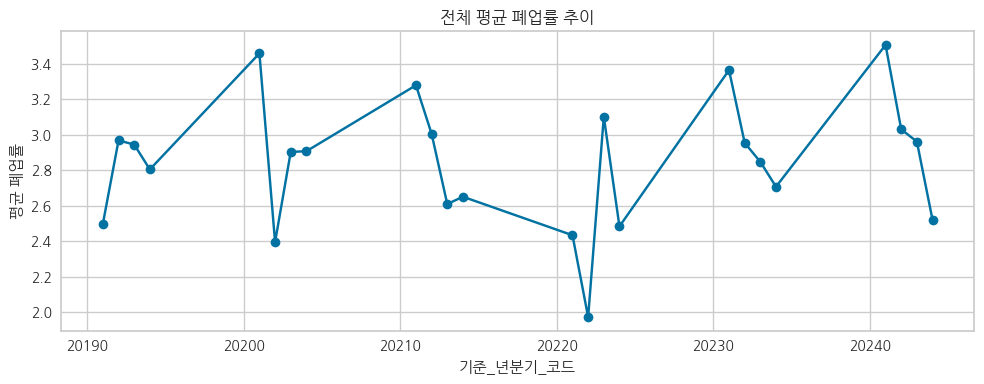

In [ ]:
df_trend = df_merged.groupby('기준_년분기_코드')['폐업률'].mean().reset_index()
df_trend = df_trend.sort_values('기준_년분기_코드')

plt.figure(figsize=(10, 4))
plt.plot(df_trend['기준_년분기_코드'], df_trend['폐업률'], marker='o')
plt.title('전체 평균 폐업률 추이')
plt.xlabel('기준_년분기_코드')
plt.ylabel('평균 폐업률')
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
# 폐업률을 예측하기가 어려운 것 같음
# 주기가 안보임

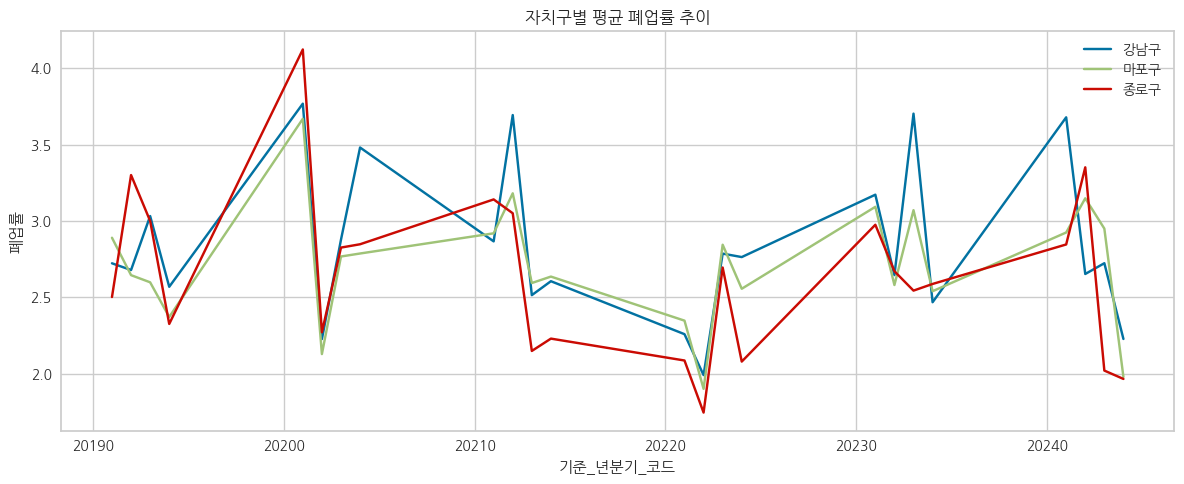

In [33]:
selected_gu = ['강남구', '마포구', '종로구']  # 원하는 자치구 리스트

plt.figure(figsize=(12, 5))
for gu in selected_gu:
    gu_trend = df_merged[df_merged['자치구'] == gu]
    gu_trend = gu_trend.groupby('기준_년분기_코드')['폐업률'].mean().reset_index()
    plt.plot(gu_trend['기준_년분기_코드'], gu_trend['폐업률'], label=gu)

plt.title('자치구별 평균 폐업률 추이')
plt.xlabel('기준_년분기_코드')
plt.ylabel('폐업률')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


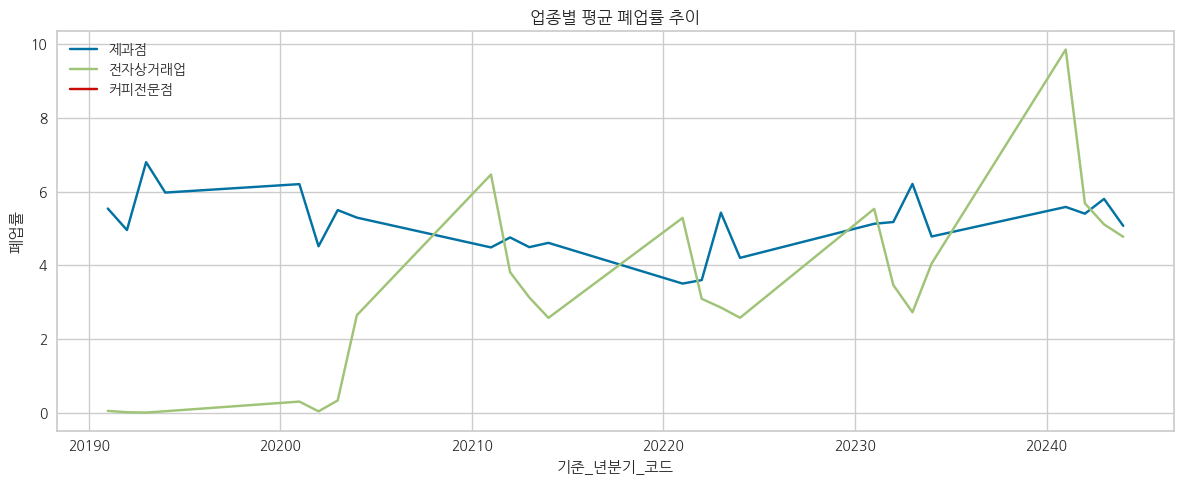

In [34]:
selected_upjong = ['제과점', '전자상거래업', '커피전문점']

plt.figure(figsize=(12, 5))
for upjong in selected_upjong:
    uj_trend = df_merged[df_merged['업종명'] == upjong]
    uj_trend = uj_trend.groupby('기준_년분기_코드')['폐업률'].mean().reset_index()
    plt.plot(uj_trend['기준_년분기_코드'], uj_trend['폐업률'], label=upjong)

plt.title('업종별 평균 폐업률 추이')
plt.xlabel('기준_년분기_코드')
plt.ylabel('폐업률')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
# 업종별로는 더욱이 폐업률 예측 어려워 보임

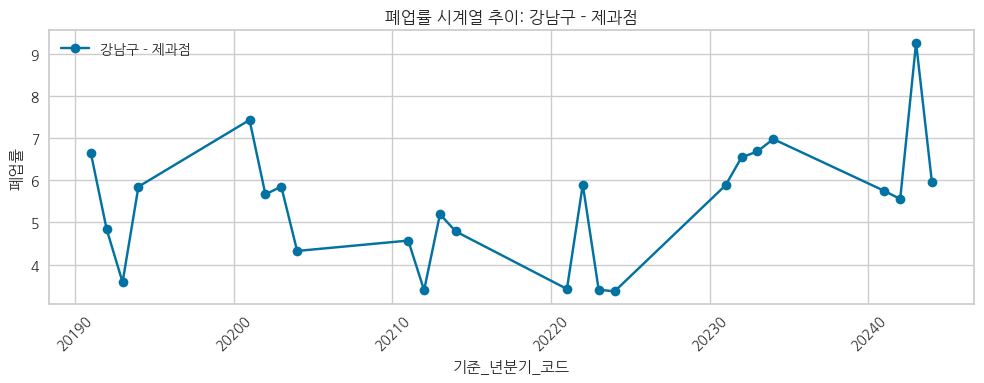

In [ ]:
# 자치구-업종별로 폐업률 

# 자치구 및 업종 선택
target_gu = '강남구'
target_upjong = '제과점'

df_trend = df_merged[
    (df_merged['자치구'] == target_gu) &
    (df_merged['업종명'] == target_upjong)
]

df_trend = df_trend.sort_values('기준_년분기_코드')

plt.figure(figsize=(10, 4))
plt.plot(df_trend['기준_년분기_코드'], df_trend['폐업률'], marker='o', label=f"{target_gu} - {target_upjong}")
plt.title(f'폐업률 시계열 추이: {target_gu} - {target_upjong}')
plt.xlabel('기준_년분기_코드')
plt.ylabel('폐업률')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


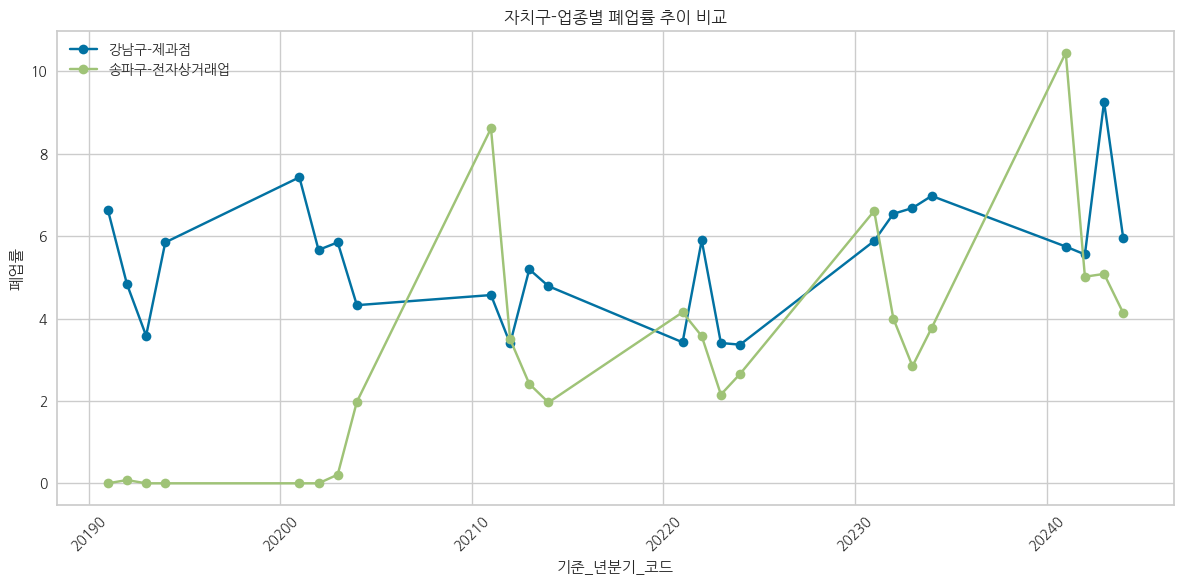

In [ ]:
targets = [
    ('강남구', '제과점'),
    ('마포구', '커피전문점'),
    ('송파구', '전자상거래업')
]

plt.figure(figsize=(12, 6))

for gu, upjong in targets:
    df_temp = df_merged[(df_merged['자치구'] == gu) & (df_merged['업종명'] == upjong)]
    df_temp = df_temp.sort_values('기준_년분기_코드')
    if not df_temp.empty:
        plt.plot(df_temp['기준_년분기_코드'], df_temp['폐업률'], marker='o', label=f"{gu}-{upjong}")

plt.title('자치구-업종별 폐업률 추이 비교')
plt.xlabel('기준_년분기_코드')
plt.ylabel('폐업률')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
# 폐업률 예측하기 너무 어려움....

### 폐업률의 시계열 주기성(계절성)을 분석

In [39]:
# 분기별 평균 폐업률 계산
df_trend = df_merged.groupby('기준_년분기_코드')['폐업률'].mean().reset_index()
df_trend = df_trend.sort_values('기준_년분기_코드')


In [40]:
# 기준_년분기_코드 → 날짜 (YYYY-Q → YYYY-MM-DD)
def convert_quarter_to_date(code):
    year = str(code)[:4]
    quarter = str(code)[-1]
    month = {'1': '01', '2': '04', '3': '07', '4': '10'}[quarter]
    return pd.to_datetime(f'{year}-{month}-01')

df_trend['ds'] = df_trend['기준_년분기_코드'].apply(convert_quarter_to_date)
df_trend = df_trend.rename(columns={'폐업률': 'y'})[['ds', 'y']]


/Users/leehyunjoo/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
20:57:54 - cmdstanpy - INFO - Chain [1] start processing
20:57:55 - cmdstanpy - INFO - Chain [1] done processing
/Users/leehyunjoo/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


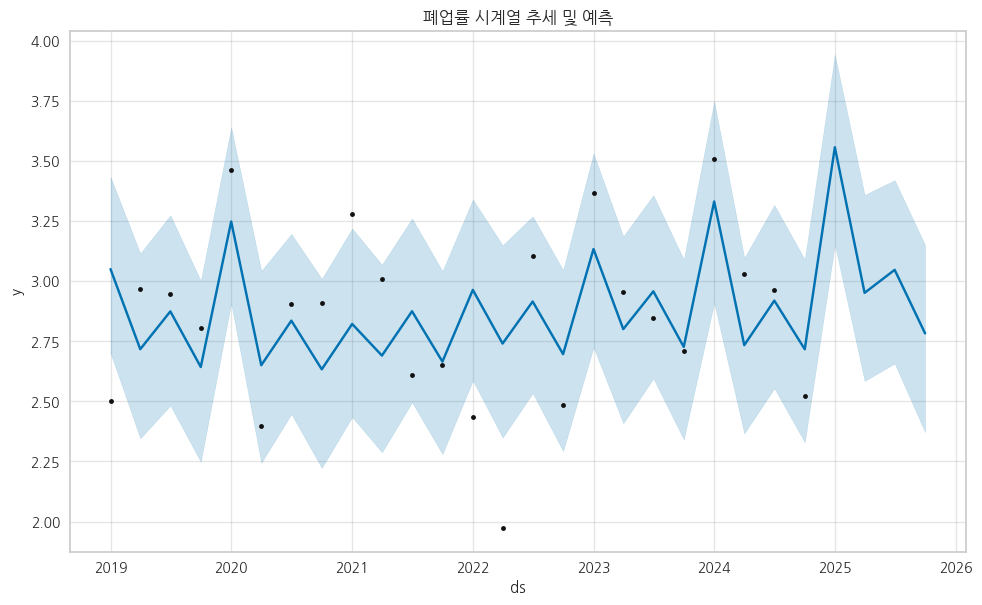

/Users/leehyunjoo/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:1415: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/leehyunjoo/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:1415: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/leehyunjoo/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:1415: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())


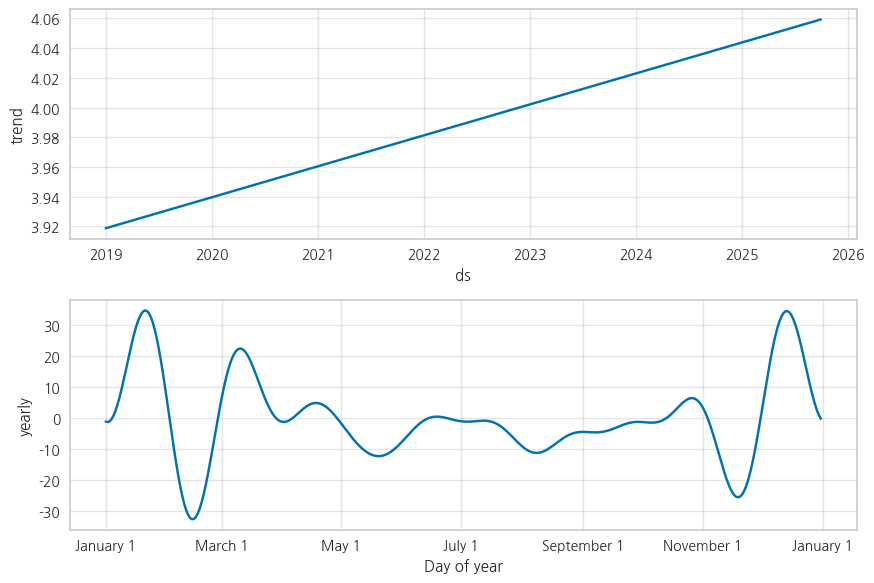

In [41]:
from prophet import Prophet
import matplotlib.pyplot as plt

model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(df_trend)

future = model.make_future_dataframe(periods=4, freq='Q')  # 1년 예측
forecast = model.predict(future)

# 전체 트렌드 + 예측 시각화
fig1 = model.plot(forecast)
plt.title("폐업률 시계열 추세 및 예측")
plt.show()

# 구성요소 분해 (추세, 계절성)
fig2 = model.plot_components(forecast)
plt.show()


In [42]:
# 폐업률 매년 상승하고 있음
# 연도 내에서 폐업률이 반복적으로 증가하거나 감소하는 패턴
# 특히 1월2월, 11월12월 즈음에 폐업률이 높아지는 경향
# 연말 정산, 상권 정비, 리뉴얼 등 비즈니스 종료 또는 정리 시기와 맞물릴 가능성이 큼
# 예측 모델 신뢰도	prophet이 해당 주기성과 추세를 잘 반영하고 있음